In [43]:
import pandas as pd
from prophet import Prophet

df = pd.read_csv('medium_posts.csv')
df['published_date'] = pd.to_datetime(df['published']).dt.date
df = df.drop(columns='published')
df.head()

,domain,url,published_date
0,medium.com,https://medium.com/policy/medium-terms-of-serv...,2012-08-13
1,medium.com,https://medium.com/policy/medium-privacy-polic...,2012-08-13
2,medium.com,https://medium.com/@Medium/personalize-your-me...,2016-11-04
3,medium.com,https://medium.com/holiday-poems/xmas-morning-...,2016-12-24
4,blog.medium.com,https://blog.medium.com/taking-a-side-on-net-n...,2015-09-22


In [44]:
df_by_day = df['published_date'].value_counts().sort_index()
df_by_day = df_by_day.to_frame()
df_by_day['ds'] = df_by_day.index
df_by_day.rename(columns={"published_date":"y"}, inplace=True)
df_by_day.head()

,y,ds
1970-01-01,2,1970-01-01
1970-01-18,3,1970-01-18
2003-09-14,1,2003-09-14
2004-04-04,1,2004-04-04
2004-04-16,1,2004-04-16


In [45]:
df_by_day = df_by_day.iloc[2:]
df_by_day.head()

,y,ds
2003-09-14,1,2003-09-14
2004-04-04,1,2004-04-04
2004-04-16,1,2004-04-16
2005-09-12,1,2005-09-12
2006-02-19,1,2006-02-19


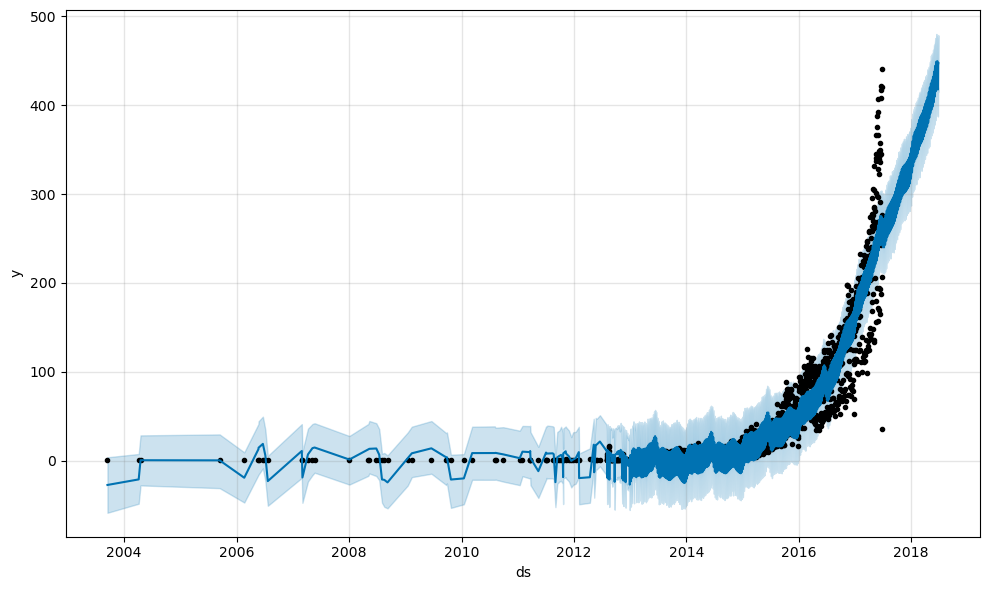

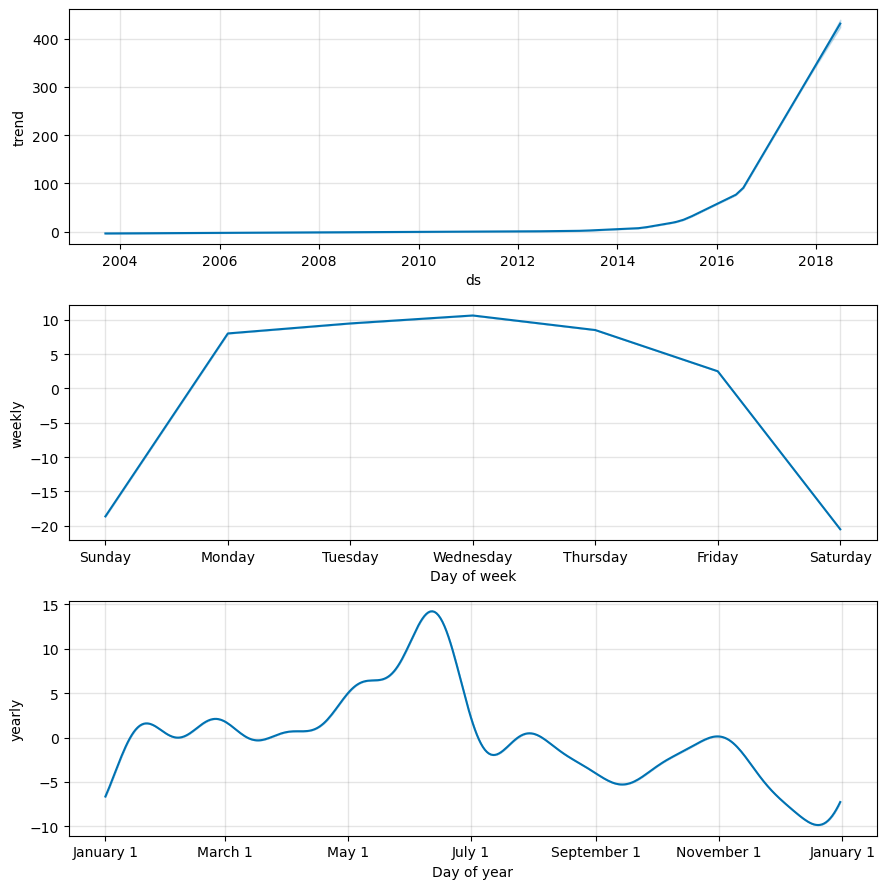

In [46]:
import logging
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
m = Prophet()
m.fit(df_by_day)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

  0%|          | 0/22 [00:00<?, ?it/s]

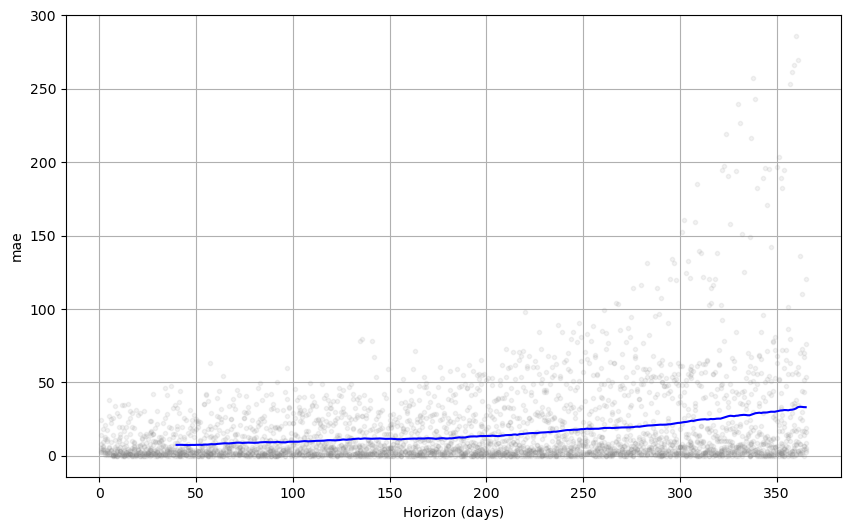

In [47]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='mae')

# Standard tuning

In [20]:
import itertools
import numpy as np
import pandas as pd

import logging
logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL)

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale' : [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode' : ['additive', 'multiplicative'],
    'changepoint_range' : [0.8, 0.95]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
maes = []

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_by_day)  # Fit model with given params
#     df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results['mae'] = maes
print(tuning_results)

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Fall

     changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                      0.001                     0.01                  0.01   
1                      0.001                     0.01                  0.01   
2                      0.001                     0.01                  0.01   
3                      0.001                     0.01                  0.01   
4                      0.001                     0.01                  0.10   
..                       ...                      ...                   ...   
251                    0.500                    10.00                  1.00   
252                    0.500                    10.00                 10.00   
253                    0.500                    10.00                 10.00   
254                    0.500                    10.00                 10.00   
255                    0.500                    10.00                 10.00   

    seasonality_mode  changepoint_range       rmse 

In [25]:
tuning_results.sort_values('mae').head(40)

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,changepoint_range,rmse,mae
198,0.5,0.01,0.10,multiplicative,0.80,27.723428,13.362756
194,0.5,0.01,0.01,multiplicative,0.80,27.723428,13.362756
202,0.5,0.01,1.00,multiplicative,0.80,27.723428,13.362756
206,0.5,0.01,10.00,multiplicative,0.80,27.723428,13.362756
223,0.5,0.10,10.00,multiplicative,0.95,28.537553,13.978967
219,0.5,0.10,1.00,multiplicative,0.95,28.537553,13.978967
211,0.5,0.10,0.01,multiplicative,0.95,28.537553,13.978967
215,0.5,0.10,0.10,multiplicative,0.95,28.537553,13.978967
231,0.5,1.00,0.10,multiplicative,0.95,28.668496,14.227942
227,0.5,1.00,0.01,multiplicative,0.95,28.668496,14.227942


In [27]:
import itertools
import numpy as np
import pandas as pd

# With different cross validation

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale' : [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode' : ['additive', 'multiplicative'],
    'changepoint_range' : [0.8, 0.95]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
maes = []

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_by_day)  # Fit model with given params
#     df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_cv = cross_validation(m, initial='3650 days', period='30 days', horizon = '90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results['mae'] = maes
print(tuning_results)

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Fall

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Fall

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Fall

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Fall

     changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                      0.001                     0.01                  0.01   
1                      0.001                     0.01                  0.01   
2                      0.001                     0.01                  0.01   
3                      0.001                     0.01                  0.01   
4                      0.001                     0.01                  0.10   
..                       ...                      ...                   ...   
251                    0.500                    10.00                  1.00   
252                    0.500                    10.00                 10.00   
253                    0.500                    10.00                 10.00   
254                    0.500                    10.00                 10.00   
255                    0.500                    10.00                 10.00   

    seasonality_mode  changepoint_range       rmse 

In [48]:
tuning_results.sort_values('mae')

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,changepoint_range,rmse,mae
203,0.500,0.01,1.00,multiplicative,0.95,20.402265,11.582359
195,0.500,0.01,0.01,multiplicative,0.95,20.402265,11.582359
207,0.500,0.01,10.00,multiplicative,0.95,20.402265,11.582359
199,0.500,0.01,0.10,multiplicative,0.95,20.402265,11.582359
223,0.500,0.10,10.00,multiplicative,0.95,24.641623,12.552768
...,...,...,...,...,...,...,...
61,0.001,10.00,10.00,additive,0.95,69.532502,45.338267
33,0.001,1.00,0.01,additive,0.95,69.578977,45.394123
37,0.001,1.00,0.10,additive,0.95,69.578977,45.394123
41,0.001,1.00,1.00,additive,0.95,69.578977,45.394123


## Second version of tuning - Optuna

In [28]:
import optuna

trials_number = 256

def objective(trial) -> float:
    changepoint_prior_scale = trial.suggest_loguniform('changepoint_prior_scale', 0.001, 1.0)
    seasonality_prior_scale = trial.suggest_loguniform('seasonality_prior_scale', 0.01, 100.0)
    holidays_prior_scale = trial.suggest_loguniform('holidays_prior_scale', 0.01, 100.0)
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])
    changepoint_range = trial.suggest_uniform('changepoint_range', 0.65, 0.95)

    m = Prophet(changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=seasonality_prior_scale,
               holidays_prior_scale=holidays_prior_scale, seasonality_mode=seasonality_mode,
               changepoint_range=changepoint_range).fit(df_by_day)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    maes.append(df_p['mae'].values[0])

    score = df_p['mae'].values[0]
    print("  MAE: {}".format(df_p['mae'].values[0]))
    print("  RMSE: {}".format(df_p['rmse'].values[0]))

    print("  Params for trial " + str(trial.number) + ": ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    return score

study_name = 'medium-study'
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, direction="minimize", storage=storage_name, load_if_exists=True,)

study.enqueue_trial({
        "changepoint_prior_scale": 0.05,
        "seasonality_prior_scale": 10.0,
        "holidays_prior_scale": 10.0,
        "seasonality_mode": "additive",
        "changepoint_range": 0.8
    })

optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=trials_number)

[I 2023-03-11 10:05:06,580] A new study created in RDB with name: medium-study
/tmp/ipykernel_7209/1253674865.py:33: ExperimentalWarning: enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
  study.enqueue_trial({
/home/jsowa/anaconda3/envs/prophetenv/lib/python3.11/site-packages/optuna/study/study.py:857: ExperimentalWarning: create_trial is experimental (supported from v2.0.0). The interface can change in the future.
  create_trial(state=TrialState.WAITING, system_attrs={"fixed_params": params})
/home/jsowa/anaconda3/envs/prophetenv/lib/python3.11/site-packages/optuna/study/study.py:856: ExperimentalWarning: add_trial is experimental (supported from v2.0.0). The interface can change in the future.
  self.add_trial(


  MAE: 16.818235785545767
  RMSE: 32.79174875469226
  Params for trial 0: 
    changepoint_prior_scale: 0.05
    seasonality_prior_scale: 10.0
    holidays_prior_scale: 10.0
    seasonality_mode: additive
    changepoint_range: 0.8
  MAE: 33.265592011026705
  RMSE: 59.45603063611651
  Params for trial 1: 
    changepoint_prior_scale: 0.001485542101997764
    seasonality_prior_scale: 8.790533021787354
    holidays_prior_scale: 0.34970061284862997
    seasonality_mode: additive
    changepoint_range: 0.9126337717691839


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


  MAE: 21.253728965957716
  RMSE: 36.76583997042801
  Params for trial 2: 
    changepoint_prior_scale: 0.0056362879647965675
    seasonality_prior_scale: 40.21934672929782
    holidays_prior_scale: 0.019594444982731208
    seasonality_mode: multiplicative
    changepoint_range: 0.787276919621028


Optimization terminated abnormally. Falling back to Newton.


  MAE: 14.317304241151742
  RMSE: 28.576293658986785
  Params for trial 3: 
    changepoint_prior_scale: 0.8088249389815799
    seasonality_prior_scale: 75.16067332661551
    holidays_prior_scale: 0.5969211017135589
    seasonality_mode: multiplicative
    changepoint_range: 0.8704826801041163


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


  MAE: 18.93145318394346
  RMSE: 33.84149795530286
  Params for trial 4: 
    changepoint_prior_scale: 0.01185635450877164
    seasonality_prior_scale: 8.618143469033354
    holidays_prior_scale: 49.39358792832427
    seasonality_mode: multiplicative
    changepoint_range: 0.6513470796784699
  MAE: 17.19348958656248
  RMSE: 31.797568122583556
  Params for trial 5: 
    changepoint_prior_scale: 0.02784749301479656
    seasonality_prior_scale: 0.5528090016440506
    holidays_prior_scale: 0.8128531765343985
    seasonality_mode: multiplicative
    changepoint_range: 0.8989231740071781
  MAE: 14.811851712045563
  RMSE: 29.174175005879476
  Params for trial 6: 
    changepoint_prior_scale: 0.33570002286273537
    seasonality_prior_scale: 2.8964701561585957
    holidays_prior_scale: 2.9294756048967647
    seasonality_mode: multiplicative
    changepoint_range: 0.7770536141725403
  MAE: 16.36681392440974
  RMSE: 30.84457640274913
  Params for trial 7: 
    changepoint_prior_scale: 0.053954387

Optimization terminated abnormally. Falling back to Newton.


  MAE: 17.310194140551474
  RMSE: 32.17900793821976
  Params for trial 19: 
    changepoint_prior_scale: 0.017567560043499946
    seasonality_prior_scale: 0.022233534869409693
    holidays_prior_scale: 0.07873767378378417
    seasonality_mode: multiplicative
    changepoint_range: 0.8267291542256356


Optimization terminated abnormally. Falling back to Newton.


  MAE: 21.785931287693597
  RMSE: 37.523638632554515
  Params for trial 20: 
    changepoint_prior_scale: 0.004907931403685695
    seasonality_prior_scale: 0.22288718147081127
    holidays_prior_scale: 0.37125166194009174
    seasonality_mode: multiplicative
    changepoint_range: 0.7559787116203018
  MAE: 13.57233651320028
  RMSE: 28.131709249658652
  Params for trial 21: 
    changepoint_prior_scale: 0.16928531052248855
    seasonality_prior_scale: 0.010927719974794959
    holidays_prior_scale: 0.1627913709653996
    seasonality_mode: multiplicative
    changepoint_range: 0.8225702075330512
  MAE: 13.686321529266818
  RMSE: 28.28336815579232
  Params for trial 22: 
    changepoint_prior_scale: 0.2039038300574954
    seasonality_prior_scale: 0.027774309848034882
    holidays_prior_scale: 0.038795622592227665
    seasonality_mode: multiplicative
    changepoint_range: 0.8407739562184835
  MAE: 15.210654611663358
  RMSE: 29.815037137136713
  Params for trial 23: 
    changepoint_prior_s

Optimization terminated abnormally. Falling back to Newton.


  MAE: 18.15596871071507
  RMSE: 34.7726955076124
  Params for trial 29: 
    changepoint_prior_scale: 0.023694115560796692
    seasonality_prior_scale: 0.08308160177168218
    holidays_prior_scale: 13.182596865991274
    seasonality_mode: additive
    changepoint_range: 0.7820561160701489
  MAE: 15.507698089791324
  RMSE: 30.102489164150025
  Params for trial 30: 
    changepoint_prior_scale: 0.08550019792369165
    seasonality_prior_scale: 0.04655507094639179
    holidays_prior_scale: 0.0627890094053272
    seasonality_mode: multiplicative
    changepoint_range: 0.7953956719351161
  MAE: 13.370431253783055
  RMSE: 27.68215117069814
  Params for trial 31: 
    changepoint_prior_scale: 0.5248274654898417
    seasonality_prior_scale: 0.01957915547344999
    holidays_prior_scale: 0.02702733359960741
    seasonality_mode: multiplicative
    changepoint_range: 0.7683964409189077
  MAE: 14.522875779677184
  RMSE: 29.35462137213964
  Params for trial 32: 
    changepoint_prior_scale: 0.24100

Optimization terminated abnormally. Falling back to Newton.


  MAE: 33.11340087320745
  RMSE: 60.68830473172967
  Params for trial 34: 
    changepoint_prior_scale: 0.0012407834263351012
    seasonality_prior_scale: 0.011508365646253502
    holidays_prior_scale: 0.19926951595609393
    seasonality_mode: multiplicative
    changepoint_range: 0.7281489494472143
  MAE: 13.517446668590914
  RMSE: 27.859365612700994
  Params for trial 35: 
    changepoint_prior_scale: 0.6715746403750502
    seasonality_prior_scale: 0.028565919866610667
    holidays_prior_scale: 0.02231397565243271
    seasonality_mode: multiplicative
    changepoint_range: 0.7758556222882788


Optimization terminated abnormally. Falling back to Newton.


  MAE: 15.82348223545582
  RMSE: 31.529796618860804
  Params for trial 36: 
    changepoint_prior_scale: 0.1240368004413015
    seasonality_prior_scale: 0.018664400675169876
    holidays_prior_scale: 0.7048764572888843
    seasonality_mode: additive
    changepoint_range: 0.8678931722432813
  MAE: 23.946267606718997
  RMSE: 41.112553315780104
  Params for trial 37: 
    changepoint_prior_scale: 0.0038608170077480833
    seasonality_prior_scale: 0.038455179356616076
    holidays_prior_scale: 0.10998743873101241
    seasonality_mode: multiplicative
    changepoint_range: 0.8943649934544268
  MAE: 14.324642328265211
  RMSE: 28.635684245786692
  Params for trial 38: 
    changepoint_prior_scale: 0.9670930449257318
    seasonality_prior_scale: 22.196417172521887
    holidays_prior_scale: 0.35420972117929567
    seasonality_mode: multiplicative
    changepoint_range: 0.9129085920446979
  MAE: 13.14997357690437
  RMSE: 27.626167622381743
  Params for trial 39: 
    changepoint_prior_scale: 0.

  MAE: 19.283512278955104
  RMSE: 34.85247023482167
  Params for trial 64: 
    changepoint_prior_scale: 0.008708603454546616
    seasonality_prior_scale: 0.015338279569327136
    holidays_prior_scale: 1.6865356936651323
    seasonality_mode: multiplicative
    changepoint_range: 0.8781154265465749
  MAE: 14.310391075128127
  RMSE: 28.770758028124103
  Params for trial 65: 
    changepoint_prior_scale: 0.39665119464669263
    seasonality_prior_scale: 6.185500684306779
    holidays_prior_scale: 2.4669253269702915
    seasonality_mode: multiplicative
    changepoint_range: 0.8526394097499459
  MAE: 13.573712901473456
  RMSE: 28.13022745333711
  Params for trial 66: 
    changepoint_prior_scale: 0.18654500585568745
    seasonality_prior_scale: 0.023438500771942157
    holidays_prior_scale: 1.0696550316833133
    seasonality_mode: multiplicative
    changepoint_range: 0.8691337340358657
  MAE: 12.827072099423997
  RMSE: 27.429689781488328
  Params for trial 67: 
    changepoint_prior_scale

  MAE: 13.666895075241834
  RMSE: 29.216349282737617
  Params for trial 92: 
    changepoint_prior_scale: 0.43558109265410533
    seasonality_prior_scale: 0.01019022165097291
    holidays_prior_scale: 0.4026131838290654
    seasonality_mode: multiplicative
    changepoint_range: 0.8971786822798533
  MAE: 13.260111216755664
  RMSE: 27.831717519649814
  Params for trial 93: 
    changepoint_prior_scale: 0.19375669638232548
    seasonality_prior_scale: 0.019272183882661036
    holidays_prior_scale: 0.47976344608527016
    seasonality_mode: multiplicative
    changepoint_range: 0.8826950745149907
  MAE: 12.786522189052514
  RMSE: 27.249427737476946
  Params for trial 94: 
    changepoint_prior_scale: 0.4488506400127721
    seasonality_prior_scale: 0.013025552975082594
    holidays_prior_scale: 18.658600297831732
    seasonality_mode: multiplicative
    changepoint_range: 0.8299933481173319
  MAE: 12.93396702105763
  RMSE: 27.248363926237506
  Params for trial 95: 
    changepoint_prior_sca

  MAE: 14.413847277132245
  RMSE: 28.69928808851577
  Params for trial 120: 
    changepoint_prior_scale: 0.9828452186694455
    seasonality_prior_scale: 0.4304990558721925
    holidays_prior_scale: 0.9453035037507866
    seasonality_mode: multiplicative
    changepoint_range: 0.8191684854230405
  MAE: 12.690906795021386
  RMSE: 26.99465059784898
  Params for trial 121: 
    changepoint_prior_scale: 0.769750623173954
    seasonality_prior_scale: 0.022254790127536814
    holidays_prior_scale: 2.2304001267289935
    seasonality_mode: multiplicative
    changepoint_range: 0.838492986582127
  MAE: 12.665623315669231
  RMSE: 26.994361153820712
  Params for trial 122: 
    changepoint_prior_scale: 0.7449445163709959
    seasonality_prior_scale: 0.021352292673035077
    holidays_prior_scale: 2.0383027452387927
    seasonality_mode: multiplicative
    changepoint_range: 0.8336489076178859
  MAE: 12.644944350476989
  RMSE: 26.97027970645525
  Params for trial 123: 
    changepoint_prior_scale: 

  MAE: 12.721112270714254
  RMSE: 27.143239429680495
  Params for trial 148: 
    changepoint_prior_scale: 0.7108403126608063
    seasonality_prior_scale: 0.023789283641513424
    holidays_prior_scale: 7.916490133335737
    seasonality_mode: multiplicative
    changepoint_range: 0.8591040737664695
  MAE: 13.39321065660783
  RMSE: 27.892912836497565
  Params for trial 149: 
    changepoint_prior_scale: 0.5264641666878285
    seasonality_prior_scale: 0.04701576259000949
    holidays_prior_scale: 3.864227940296623
    seasonality_mode: multiplicative
    changepoint_range: 0.8486720023739853
  MAE: 12.8556938736191
  RMSE: 27.24886978219839
  Params for trial 150: 
    changepoint_prior_scale: 0.851545521385047
    seasonality_prior_scale: 0.030788298628723607
    holidays_prior_scale: 2.7934352818512584
    seasonality_mode: multiplicative
    changepoint_range: 0.8359295705903358
  MAE: 12.694778129352892
  RMSE: 27.012173241401737
  Params for trial 151: 
    changepoint_prior_scale: 0

  MAE: 12.624954876999869
  RMSE: 26.895085435588992
  Params for trial 176: 
    changepoint_prior_scale: 0.7235922355202192
    seasonality_prior_scale: 0.018649070795591336
    holidays_prior_scale: 7.818209658285996
    seasonality_mode: multiplicative
    changepoint_range: 0.8560088740933015
  MAE: 12.743824619385352
  RMSE: 27.125721259751227
  Params for trial 177: 
    changepoint_prior_scale: 0.9879879152133114
    seasonality_prior_scale: 0.02724197067986341
    holidays_prior_scale: 8.505143767344837
    seasonality_mode: multiplicative
    changepoint_range: 0.8576742463250951
  MAE: 12.62714442486687
  RMSE: 26.965233765084243
  Params for trial 178: 
    changepoint_prior_scale: 0.7449289522678681
    seasonality_prior_scale: 0.021152744063486054
    holidays_prior_scale: 6.145043600803542
    seasonality_mode: multiplicative
    changepoint_range: 0.8512657257980604
  MAE: 12.621601584426807
  RMSE: 26.964327941861846
  Params for trial 179: 
    changepoint_prior_scale

  MAE: 12.623697104291328
  RMSE: 26.90342113991912
  Params for trial 204: 
    changepoint_prior_scale: 0.7634421009565117
    seasonality_prior_scale: 0.01634661567997987
    holidays_prior_scale: 13.078528984981459
    seasonality_mode: multiplicative
    changepoint_range: 0.8685025763960699
  MAE: 12.638184130862522
  RMSE: 26.92385429784208
  Params for trial 205: 
    changepoint_prior_scale: 0.847688189963159
    seasonality_prior_scale: 0.016365813485404248
    holidays_prior_scale: 12.513377120189936
    seasonality_mode: multiplicative
    changepoint_range: 0.8679102907997277
  MAE: 12.61517160301506
  RMSE: 26.988518428370842
  Params for trial 206: 
    changepoint_prior_scale: 0.5470528361195333
    seasonality_prior_scale: 0.01683638323694367
    holidays_prior_scale: 17.767052342419717
    seasonality_mode: multiplicative
    changepoint_range: 0.8699385609622009
  MAE: 14.985561590029993
  RMSE: 31.093558573066957
  Params for trial 207: 
    changepoint_prior_scale:

Optimization terminated abnormally. Falling back to Newton.


  MAE: 21.352585604313873
  RMSE: 37.67143508824304
  Params for trial 230: 
    changepoint_prior_scale: 0.005411037339603246
    seasonality_prior_scale: 0.018434977585643064
    holidays_prior_scale: 14.237298669053374
    seasonality_mode: multiplicative
    changepoint_range: 0.8587778833082823
  MAE: 12.67450868863938
  RMSE: 26.975888717390426
  Params for trial 231: 
    changepoint_prior_scale: 0.7687261177570679
    seasonality_prior_scale: 0.014790858958470245
    holidays_prior_scale: 15.079751702638125
    seasonality_mode: multiplicative
    changepoint_range: 0.8738624399588467
  MAE: 12.632981997238312
  RMSE: 26.900490287878046
  Params for trial 232: 
    changepoint_prior_scale: 0.6890584751020423
    seasonality_prior_scale: 0.017998979222545567
    holidays_prior_scale: 7.850417313143024
    seasonality_mode: multiplicative
    changepoint_range: 0.8802133783334491
  MAE: 12.677570354168259
  RMSE: 27.08877460668373
  Params for trial 233: 
    changepoint_prior_sc

In [29]:
print("\nBest trial:")
trial = study.best_trial

print("  MAE: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


Best trial:
  MAE: 12.599942852088063
  Params: 
    changepoint_prior_scale: 0.6316244803121108
    changepoint_range: 0.8707253493699799
    holidays_prior_scale: 9.467928324944635
    seasonality_mode: multiplicative
    seasonality_prior_scale: 0.01632487700072758


In [30]:
import optuna

trials_number = 256

# With different cross validation

def objective(trial) -> float:
    changepoint_prior_scale = trial.suggest_loguniform('changepoint_prior_scale', 0.001, 1.0)
    seasonality_prior_scale = trial.suggest_loguniform('seasonality_prior_scale', 0.01, 100.0)
    holidays_prior_scale = trial.suggest_loguniform('holidays_prior_scale', 0.01, 100.0)
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])
    changepoint_range = trial.suggest_uniform('changepoint_range', 0.65, 0.95)

    m = Prophet(changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=seasonality_prior_scale,
               holidays_prior_scale=holidays_prior_scale, seasonality_mode=seasonality_mode,
               changepoint_range=changepoint_range).fit(df_by_day)  # Fit model with given params
    df_cv = cross_validation(m, initial='3650 days', period='30 days', horizon = '90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    maes.append(df_p['mae'].values[0])

    score = df_p['mae'].values[0]
    print("  MAE: {}".format(df_p['mae'].values[0]))
    print("  RMSE: {}".format(df_p['rmse'].values[0]))

    print("  Params for trial " + str(trial.number) + ": ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    return score

study_name = 'medium-study2'
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, direction="minimize", storage=storage_name, load_if_exists=True,)

study.enqueue_trial({
        "changepoint_prior_scale": 0.05,
        "seasonality_prior_scale": 10.0,
        "holidays_prior_scale": 10.0,
        "seasonality_mode": "additive",
        "changepoint_range": 0.8
    })

optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=trials_number)

/tmp/ipykernel_7209/4240329951.py:35: ExperimentalWarning: enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
  study.enqueue_trial({
/home/jsowa/anaconda3/envs/prophetenv/lib/python3.11/site-packages/optuna/study/study.py:857: ExperimentalWarning: create_trial is experimental (supported from v2.0.0). The interface can change in the future.
  create_trial(state=TrialState.WAITING, system_attrs={"fixed_params": params})
/home/jsowa/anaconda3/envs/prophetenv/lib/python3.11/site-packages/optuna/study/study.py:856: ExperimentalWarning: add_trial is experimental (supported from v2.0.0). The interface can change in the future.
  self.add_trial(
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


  MAE: 16.374195802948655
  RMSE: 29.060947615113253
  Params for trial 0: 
    changepoint_prior_scale: 0.05
    seasonality_prior_scale: 10.0
    holidays_prior_scale: 10.0
    seasonality_mode: additive
    changepoint_range: 0.8
  MAE: 13.234316161323486
  RMSE: 25.46236153978387
  Params for trial 1: 
    changepoint_prior_scale: 0.2267035253983645
    seasonality_prior_scale: 2.3212622464399266
    holidays_prior_scale: 25.610915421048844
    seasonality_mode: multiplicative
    changepoint_range: 0.9488233523261165
  MAE: 31.034856210402864
  RMSE: 47.24897493045723
  Params for trial 2: 
    changepoint_prior_scale: 0.003317877060359826
    seasonality_prior_scale: 0.012098508098056288
    holidays_prior_scale: 2.0589416545423345
    seasonality_mode: additive
    changepoint_range: 0.934784960202429
  MAE: 12.920589155748369
  RMSE: 25.54141222511673
  Params for trial 3: 
    changepoint_prior_scale: 0.41829638650269696
    seasonality_prior_scale: 0.10071082338914286
    hol

Optimization terminated abnormally. Falling back to Newton.


  MAE: 14.923995132512033
  RMSE: 28.884555194619185
  Params for trial 5: 
    changepoint_prior_scale: 0.35723697076873634
    seasonality_prior_scale: 0.10121464398046127
    holidays_prior_scale: 0.5750232236562638
    seasonality_mode: multiplicative
    changepoint_range: 0.6732678166990034


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Fall

  MAE: 21.603171762193295
  RMSE: 35.496802624474554
  Params for trial 6: 
    changepoint_prior_scale: 0.007168831199598106
    seasonality_prior_scale: 11.831760528537531
    holidays_prior_scale: 1.1786844206962237
    seasonality_mode: additive
    changepoint_range: 0.704099478967456
  MAE: 40.17525478680979
  RMSE: 63.0863989915993
  Params for trial 7: 
    changepoint_prior_scale: 0.0015917932418786438
    seasonality_prior_scale: 0.013865224920266582
    holidays_prior_scale: 0.028123491749521484
    seasonality_mode: multiplicative
    changepoint_range: 0.7062070705934407


Optimization terminated abnormally. Falling back to Newton.


  MAE: 16.07653158639026
  RMSE: 28.998706431137453
  Params for trial 8: 
    changepoint_prior_scale: 0.08897311564605674
    seasonality_prior_scale: 0.12576350824961025
    holidays_prior_scale: 49.022454109499215
    seasonality_mode: additive
    changepoint_range: 0.7667652875276788


Optimization terminated abnormally. Falling back to Newton.


  MAE: 22.76858870902661
  RMSE: 35.27672341151226
  Params for trial 9: 
    changepoint_prior_scale: 0.00544946345747885
    seasonality_prior_scale: 3.8133756706642865
    holidays_prior_scale: 0.550733725420725
    seasonality_mode: multiplicative
    changepoint_range: 0.8265040141586437


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


  MAE: 17.406458362096778
  RMSE: 30.09277817133571
  Params for trial 10: 
    changepoint_prior_scale: 0.018243763035210057
    seasonality_prior_scale: 0.32275596732549183
    holidays_prior_scale: 0.024423795082683608
    seasonality_mode: multiplicative
    changepoint_range: 0.8631260349371793
  MAE: 13.45204881665114
  RMSE: 25.863043917869252
  Params for trial 11: 
    changepoint_prior_scale: 0.18256770706018546
    seasonality_prior_scale: 1.3056672125587003
    holidays_prior_scale: 0.12173481236338095
    seasonality_mode: multiplicative
    changepoint_range: 0.877328605203309
  MAE: 13.196672795150343
  RMSE: 26.299497599813666
  Params for trial 12: 
    changepoint_prior_scale: 0.8848449919671838
    seasonality_prior_scale: 0.861609603935206
    holidays_prior_scale: 5.42610313688678
    seasonality_mode: multiplicative
    changepoint_range: 0.7712275988239539
  MAE: 13.298495690292187
  RMSE: 26.494446017940085
  Params for trial 13: 
    changepoint_prior_scale: 0.

Optimization terminated abnormally. Falling back to Newton.


  MAE: 15.816964902312973
  RMSE: 28.72041042931885
  Params for trial 18: 
    changepoint_prior_scale: 0.02192314881348983
    seasonality_prior_scale: 0.03422454677043695
    holidays_prior_scale: 0.09728025697143138
    seasonality_mode: multiplicative
    changepoint_range: 0.8624320282438548
  MAE: 13.737206097797207
  RMSE: 26.633074399563593
  Params for trial 19: 
    changepoint_prior_scale: 0.1308744066286476
    seasonality_prior_scale: 0.14473812786399504
    holidays_prior_scale: 0.05528692574886492
    seasonality_mode: multiplicative
    changepoint_range: 0.8028773365522399
  MAE: 14.995698837836704
  RMSE: 27.941109192204756
  Params for trial 20: 
    changepoint_prior_scale: 0.03312706338950757
    seasonality_prior_scale: 0.03778222677561861
    holidays_prior_scale: 0.2728469648000544
    seasonality_mode: multiplicative
    changepoint_range: 0.8855074042729209
  MAE: 13.218289879336
  RMSE: 25.923317351129892
  Params for trial 21: 
    changepoint_prior_scale: 

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


  MAE: 16.26393633032732
  RMSE: 28.411320339508546
  Params for trial 29: 
    changepoint_prior_scale: 0.04460940370995376
    seasonality_prior_scale: 0.019385978583555695
    holidays_prior_scale: 0.02251706629847065
    seasonality_mode: additive
    changepoint_range: 0.9071235999002024
  MAE: 12.438425043278427
  RMSE: 24.62438380143005
  Params for trial 30: 
    changepoint_prior_scale: 0.5045674969175391
    seasonality_prior_scale: 0.06587500821292513
    holidays_prior_scale: 0.052029809361569535
    seasonality_mode: multiplicative
    changepoint_range: 0.8860668277130946
  MAE: 12.027790483951787
  RMSE: 23.885626835764906
  Params for trial 31: 
    changepoint_prior_scale: 0.21536314560965616
    seasonality_prior_scale: 0.022346146614806297
    holidays_prior_scale: 0.0526587587138699
    seasonality_mode: multiplicative
    changepoint_range: 0.8788528830852904
  MAE: 12.01226075578804
  RMSE: 21.717029946875314
  Params for trial 32: 
    changepoint_prior_scale: 0.

  MAE: 11.703089791760599
  RMSE: 22.95786452120353
  Params for trial 57: 
    changepoint_prior_scale: 0.46148187829083365
    seasonality_prior_scale: 0.023248331227167785
    holidays_prior_scale: 20.523205339511783
    seasonality_mode: multiplicative
    changepoint_range: 0.9328893054544443
  MAE: 12.355402943188059
  RMSE: 24.44787431558879
  Params for trial 58: 
    changepoint_prior_scale: 0.40406791987952373
    seasonality_prior_scale: 0.061376635151477996
    holidays_prior_scale: 19.25162242665055
    seasonality_mode: multiplicative
    changepoint_range: 0.9355477809923227
  MAE: 12.448843195678126
  RMSE: 24.66428157232719
  Params for trial 59: 
    changepoint_prior_scale: 0.164885739048294
    seasonality_prior_scale: 0.033529684917815786
    holidays_prior_scale: 11.695729252718378
    seasonality_mode: multiplicative
    changepoint_range: 0.9239771283946537
  MAE: 14.795024428298186
  RMSE: 24.646277356028854
  Params for trial 60: 
    changepoint_prior_scale: 

Optimization terminated abnormally. Falling back to Newton.


  MAE: 16.959560257428215
  RMSE: 29.898839173031384
  Params for trial 67: 
    changepoint_prior_scale: 0.011897364963550863
    seasonality_prior_scale: 0.021883340544572367
    holidays_prior_scale: 7.787663993641832
    seasonality_mode: multiplicative
    changepoint_range: 0.8926341873153871
  MAE: 23.192289518992595
  RMSE: 36.15288642247057
  Params for trial 68: 
    changepoint_prior_scale: 0.004252020709033823
    seasonality_prior_scale: 0.02833213658552809
    holidays_prior_scale: 1.2431477186446556
    seasonality_mode: multiplicative
    changepoint_range: 0.9142155199752169
  MAE: 12.934849679044126
  RMSE: 25.182420821852048
  Params for trial 69: 
    changepoint_prior_scale: 0.4036727856324134
    seasonality_prior_scale: 0.17933531941229486
    holidays_prior_scale: 0.8645048505645042
    seasonality_mode: multiplicative
    changepoint_range: 0.8705490707950184
  MAE: 11.479292886069524
  RMSE: 21.10441335470403
  Params for trial 70: 
    changepoint_prior_scale

  MAE: 16.562816020393516
  RMSE: 29.158884105612763
  Params for trial 95: 
    changepoint_prior_scale: 0.025515711560061653
    seasonality_prior_scale: 5.112965074919025
    holidays_prior_scale: 10.7797067819282
    seasonality_mode: multiplicative
    changepoint_range: 0.9322367735671869
  MAE: 42.22444837159065
  RMSE: 66.90349552085192
  Params for trial 96: 
    changepoint_prior_scale: 0.001053640886589301
    seasonality_prior_scale: 0.016191525981895754
    holidays_prior_scale: 2.2770852252076943
    seasonality_mode: multiplicative
    changepoint_range: 0.9441504543954992
  MAE: 11.729478581319878
  RMSE: 22.403715809611313
  Params for trial 97: 
    changepoint_prior_scale: 0.8649149231172001
    seasonality_prior_scale: 0.019814558412049203
    holidays_prior_scale: 3.059875915930096
    seasonality_mode: multiplicative
    changepoint_range: 0.9498655779211171
  MAE: 11.769280764202762
  RMSE: 23.219715047212144
  Params for trial 98: 
    changepoint_prior_scale: 0

  MAE: 11.514084482912297
  RMSE: 21.926573740273273
  Params for trial 123: 
    changepoint_prior_scale: 0.9841002763409153
    seasonality_prior_scale: 0.01948512539279552
    holidays_prior_scale: 21.80729073506543
    seasonality_mode: multiplicative
    changepoint_range: 0.8980051242387046
  MAE: 11.485837534093537
  RMSE: 21.043332756221584
  Params for trial 124: 
    changepoint_prior_scale: 0.7136981847065502
    seasonality_prior_scale: 0.013350496352144183
    holidays_prior_scale: 15.676226069645406
    seasonality_mode: multiplicative
    changepoint_range: 0.8796796150190808
  MAE: 11.505857730066364
  RMSE: 21.85666234930719
  Params for trial 125: 
    changepoint_prior_scale: 0.8533491696798088
    seasonality_prior_scale: 0.018823936766727434
    holidays_prior_scale: 27.558978564995403
    seasonality_mode: multiplicative
    changepoint_range: 0.9066471099252705
  MAE: 11.90442361340747
  RMSE: 23.560612301655983
  Params for trial 126: 
    changepoint_prior_scal

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


  MAE: 13.2214163953541
  RMSE: 25.062459304831656
  Params for trial 134: 
    changepoint_prior_scale: 0.050213095914567546
    seasonality_prior_scale: 0.01291139028009103
    holidays_prior_scale: 32.290295120019444
    seasonality_mode: multiplicative
    changepoint_range: 0.8760220171002155
  MAE: 11.390427588487912
  RMSE: 20.614317507038518
  Params for trial 135: 
    changepoint_prior_scale: 0.7986784469710932
    seasonality_prior_scale: 0.012526639900699363
    holidays_prior_scale: 9.937967762926165
    seasonality_mode: multiplicative
    changepoint_range: 0.8957673452195964
  MAE: 11.392547723529557
  RMSE: 20.50509553116873
  Params for trial 136: 
    changepoint_prior_scale: 0.7769765946312842
    seasonality_prior_scale: 0.012046801959979312
    holidays_prior_scale: 10.762153326214689
    seasonality_mode: multiplicative
    changepoint_range: 0.8934463654255672
  MAE: 11.644177053113044
  RMSE: 21.132396535613726
  Params for trial 137: 
    changepoint_prior_sca

  MAE: 12.833868928504673
  RMSE: 25.551010414549097
  Params for trial 162: 
    changepoint_prior_scale: 0.9759391009087909
    seasonality_prior_scale: 0.013896131449004397
    holidays_prior_scale: 13.894714026878177
    seasonality_mode: multiplicative
    changepoint_range: 0.7478668437105519
  MAE: 11.472744040229937
  RMSE: 20.062498340362083
  Params for trial 163: 
    changepoint_prior_scale: 0.8647886835350547
    seasonality_prior_scale: 0.010014758058029923
    holidays_prior_scale: 11.13691914985039
    seasonality_mode: multiplicative
    changepoint_range: 0.9000814181206148
  MAE: 11.528768373541572
  RMSE: 21.709604706129817
  Params for trial 164: 
    changepoint_prior_scale: 0.9993103715096723
    seasonality_prior_scale: 0.017636146971464633
    holidays_prior_scale: 18.423102554817188
    seasonality_mode: multiplicative
    changepoint_range: 0.9171208684598386
  MAE: 30.27291089685389
  RMSE: 45.36513367291565
  Params for trial 165: 
    changepoint_prior_sca

  MAE: 11.75259337500601
  RMSE: 21.781883105554385
  Params for trial 190: 
    changepoint_prior_scale: 0.7646974455709566
    seasonality_prior_scale: 0.01438799595884933
    holidays_prior_scale: 0.28361076013287695
    seasonality_mode: multiplicative
    changepoint_range: 0.836641296098699
  MAE: 11.45116936192769
  RMSE: 20.018933394534177
  Params for trial 191: 
    changepoint_prior_scale: 0.8476274853324418
    seasonality_prior_scale: 0.010049346097699006
    holidays_prior_scale: 0.47638790635783723
    seasonality_mode: multiplicative
    changepoint_range: 0.9022610921791219
  MAE: 12.881323136163603
  RMSE: 25.292446966057174
  Params for trial 192: 
    changepoint_prior_scale: 0.9072163608087367
    seasonality_prior_scale: 2.406125666663586
    holidays_prior_scale: 7.052218407738861
    seasonality_mode: multiplicative
    changepoint_range: 0.8923238323668128
  MAE: 11.391823205576953
  RMSE: 20.394922331767418
  Params for trial 193: 
    changepoint_prior_scale:

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


  MAE: 12.828126334597773
  RMSE: 23.95532890028986
  Params for trial 215: 
    changepoint_prior_scale: 0.06724476118100163
    seasonality_prior_scale: 0.011433743551589411
    holidays_prior_scale: 5.65524663730359
    seasonality_mode: multiplicative
    changepoint_range: 0.9044362602882462
  MAE: 11.459467577369212
  RMSE: 21.36648751011781
  Params for trial 216: 
    changepoint_prior_scale: 0.8499665292981499
    seasonality_prior_scale: 0.016216046493823112
    holidays_prior_scale: 7.079840772641747
    seasonality_mode: multiplicative
    changepoint_range: 0.9057557520766861
  MAE: 11.440417486305513
  RMSE: 20.721367473966296
  Params for trial 217: 
    changepoint_prior_scale: 0.8756670964111417
    seasonality_prior_scale: 0.01302999964745531
    holidays_prior_scale: 6.340080988910365
    seasonality_mode: multiplicative
    changepoint_range: 0.9165734901250597


Optimization terminated abnormally. Falling back to Newton.


  MAE: 11.570066433464346
  RMSE: 21.979091543781017
  Params for trial 218: 
    changepoint_prior_scale: 0.7571930221176951
    seasonality_prior_scale: 0.018243846054078645
    holidays_prior_scale: 4.453577943998247
    seasonality_mode: multiplicative
    changepoint_range: 0.8943120408152458
  MAE: 22.92996927770955
  RMSE: 37.086984890532726
  Params for trial 219: 
    changepoint_prior_scale: 0.006045385329906524
    seasonality_prior_scale: 0.01016997187868529
    holidays_prior_scale: 7.313989629339875
    seasonality_mode: additive
    changepoint_range: 0.8997428088412188
  MAE: 11.432313240554574
  RMSE: 20.889860346892323
  Params for trial 220: 
    changepoint_prior_scale: 0.8765436388013365
    seasonality_prior_scale: 0.013705413694374353
    holidays_prior_scale: 12.093213684478588
    seasonality_mode: multiplicative
    changepoint_range: 0.8911224265451139
  MAE: 11.37806364457275
  RMSE: 20.832294740634516
  Params for trial 221: 
    changepoint_prior_scale: 0.

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


  MAE: 13.978329350903254
  RMSE: 25.624093809195305
  Params for trial 224: 
    changepoint_prior_scale: 0.034420301962225903
    seasonality_prior_scale: 0.01001956503637424
    holidays_prior_scale: 5.971220086154017
    seasonality_mode: multiplicative
    changepoint_range: 0.9050511958359709
  MAE: 11.48545530359757
  RMSE: 21.018066226521526
  Params for trial 225: 
    changepoint_prior_scale: 0.7843230082475261
    seasonality_prior_scale: 0.013770135348707527
    holidays_prior_scale: 4.265330027460963
    seasonality_mode: multiplicative
    changepoint_range: 0.9224620749115688
  MAE: 11.400743217580139
  RMSE: 20.520715370491484
  Params for trial 226: 
    changepoint_prior_scale: 0.795172523299902
    seasonality_prior_scale: 0.012121434955381892
    holidays_prior_scale: 5.128531977317919
    seasonality_mode: multiplicative
    changepoint_range: 0.8985072434768455
  MAE: 11.68967822016368
  RMSE: 22.567480704404712
  Params for trial 227: 
    changepoint_prior_scale

  MAE: 11.41468103321981
  RMSE: 20.427099677242328
  Params for trial 252: 
    changepoint_prior_scale: 0.7832640291948314
    seasonality_prior_scale: 0.01193158561229411
    holidays_prior_scale: 10.52282687764256
    seasonality_mode: multiplicative
    changepoint_range: 0.9046225852277704
  MAE: 11.377924591393484
  RMSE: 20.992328096796133
  Params for trial 253: 
    changepoint_prior_scale: 0.998371064980252
    seasonality_prior_scale: 0.015222934354462512
    holidays_prior_scale: 12.80505141976474
    seasonality_mode: multiplicative
    changepoint_range: 0.900198365854344
  MAE: 13.003313479340385
  RMSE: 26.39326408047694
  Params for trial 254: 
    changepoint_prior_scale: 0.9909875175258918
    seasonality_prior_scale: 0.016090157626181732
    holidays_prior_scale: 13.649899100169499
    seasonality_mode: multiplicative
    changepoint_range: 0.7082291258992043
  MAE: 14.661718270828032
  RMSE: 24.435896666620266
  Params for trial 255: 
    changepoint_prior_scale: 

In [31]:
print("\nBest trial:")
trial = study.best_trial

print("  MAE: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


Best trial:
  MAE: 11.332321812649495
  Params: 
    changepoint_prior_scale: 0.9950646833198432
    changepoint_range: 0.8965517663940892
    holidays_prior_scale: 9.70469494033324
    seasonality_mode: multiplicative
    seasonality_prior_scale: 0.01174167053507389
